# Final_PJT 

1. 데이터 summary & read
<br></br>
2. EDA
- 고객
  - 고객 state에 따른 분포도
  - 가격별 고객 state 
  - 배송비별 고객 state
  - city에 따른 고객 분포도

- 상품
  - 상관계수
  - 카테고리별 주문 수
  - 지역별 best 상품
  - 카테고리별 상품 수
  - 상품 크기 분포

- 주문
  - 주문별 결제 수단
  - 주문 상태'취소'
  - 일자(년도, 월, 요일, 시간)에 따른 주문건수
  - 지역(state, city)에 따른 주문건수

- 판매
  - state별 판매자 분포
  - 카테고리 판매량
  - seller_id별 상품판매
  - 상품판매에 따른 매출
  - 상품유통서비스세(tax) 와 review_score, price, freight_value, customer_state_code, seller_state_code, customer unique id

- 금액
  - 주문별 결제수단 확인
  - 날짜에 따른 가격변화
  
- 리뷰
  - 리뷰 평점 분포
  - WordCloud
  - review_score기준 데이터 분리 후 N-Gram 분석
  
- 배송
  - order_status를 활용한 분석
  - 배송날짜에 따른 유통과정 date 파악
  - 날짜에 따른 배송상태
  - 배송지역
<br></br>

---

## 1. 데이터 summary 및 read

출처 : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- 1) olist_customers_dataset
- 2) olist_geolocation_dataset
- 3) olist_order_items_dataset
- 4) olist_order_payments_dataset
- 5) olist_order_reviews_dataset
- 6) olist_orders_dataset
- 7) olist_products_dataset
- 8) olist_sellers_dataset
- 9) product_category_name_translation

### 1) 라이브러리 및 데이터 로드

In [ ]:
#!pip install folium
#!pip install mysql-connector-python
# !pip install pymysql

# !pip install sqlalchemy pymysql

In [278]:
# 라이브러리 로드
import mysql.connector
from sqlalchemy import create_engine, text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import rc
from plotly import tools
import plotly.offline as py
import folium
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

plt.rcParams['axes.unicode_minus'] = False
rc("font", family="Malgun Gothic")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jiwoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [279]:
olist_customer = pd.read_csv('../dataset/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('../dataset/olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv('../dataset/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('../dataset/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('../dataset/olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv('../dataset/olist_orders_dataset.csv')
olist_products = pd.read_csv('../dataset/olist_products_dataset.csv')
olist_sellers = pd.read_csv('../dataset/olist_sellers_dataset.csv')
olist_products_name_translation = pd.read_csv("../dataset/product_category_name_translation.csv")

In [280]:
# 각 데이터셋의 shape 확인
def shape_each_dataset(df, dataset_name="df"):
    print(f"{dataset_name} 의 데이터는 {df.shape[0]} dataset /  {df.shape[1]} 의 열로 구성")
    
    return df.shape[0], df.shape[1]

In [281]:
customer_r, customer_c = shape_each_dataset(olist_customer, "Olist Customer")
geolocation_r, geolocation_c = shape_each_dataset(olist_geolocation, "Olist Geolocation")
order_items_r, order_items_c = shape_each_dataset(olist_order_items, "Olist Order Items")
order_payments_r, order_payments_c = shape_each_dataset(olist_order_payments, "Olist Order Payments")
order_reviews_r, order_reviews_c = shape_each_dataset(olist_order_reviews, "Olist Order Reviews")
orders_r, orders_c = shape_each_dataset(olist_orders, "Olist Orders")
products_r, products_c = shape_each_dataset(olist_products, "Olist Products")
sellers_r, sellers_c = shape_each_dataset(olist_sellers, "Olist Sellers")

Olist Customer 의 데이터는 99441 dataset /  5 의 열로 구성
Olist Geolocation 의 데이터는 1000163 dataset /  5 의 열로 구성
Olist Order Items 의 데이터는 112650 dataset /  7 의 열로 구성
Olist Order Payments 의 데이터는 103886 dataset /  5 의 열로 구성
Olist Order Reviews 의 데이터는 99224 dataset /  7 의 열로 구성
Olist Orders 의 데이터는 99441 dataset /  8 의 열로 구성
Olist Products 의 데이터는 32951 dataset /  9 의 열로 구성
Olist Sellers 의 데이터는 3095 dataset /  4 의 열로 구성


AWS RDS Database 연결

In [ ]:
# MySQL 연결 정보
host = 'database-1.crtsqbi21zdv.ap-northeast-1.rds.amazonaws.com'
port = 3306
user = 'admin'
password = 'zerobase'
database = 'zerobase'

# 데이터베이스 연결
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')
conn=engine.connect()


# 데이터 
table_name = ['customer', 'geolocation', 'order_items','order_payments','order_reviews','orders','products','sellers','products_name_translation']
olist_customer.to_sql(name='customer', con=engine, if_exists='replace', index=False)

olist_order_items.to_sql(name='order_items', con=engine, if_exists='replace', index=False)
olist_order_payments.to_sql(name='order_payments', con=engine, if_exists='replace', index=False)
olist_order_reviews.to_sql(name='order_reviews', con=engine, if_exists='replace', index=False)
olist_orders.to_sql(name='orders', con=engine, if_exists='replace', index=False)
olist_products.to_sql(name='products', con=engine, if_exists='replace', index=False)
olist_sellers.to_sql(name='sellers', con=engine, if_exists='replace', index=False)
olist_products_name_translation.to_sql(name='products_name_translation', con=engine, if_exists='replace', index=False)
# olist_geolocation.to_sql(name='geolocation', con=engine, if_exists='replace', index=False)

In [283]:
# https://www.kaggle.com/code/gustavofelici/sql-mining-for-features-to-predict-order-score
# 쿼리문 작성하여 출력

def get_query(query):   
  return pd.read_sql_query(text(query), conn)



In [284]:
# 데이터 확인

query="""
show tables;
"""
    
get_query(query)

,Tables_in_zerobase
0,customer
1,order_items
2,order_payments
3,order_reviews
4,orders
5,products
6,products_name_translation
7,sellers
8,state_tax


In [181]:
datasets = [olist_customer, olist_geolocation, olist_order_items, 
            olist_order_payments,  olist_order_reviews, olist_orders, 
            olist_products, olist_sellers, olist_products_name_translation]

titles = ["customers", "geolocation", "items", "payments", "reviews",
         "orders", "products", "sellers", "category_translation"]

data_summary = pd.DataFrame({},)
data_summary['datasets']= titles
data_summary['columns'] = [', '.join([col for col, null in data.isnull().sum().items() ]) for data in datasets]
data_summary['total_rows']= [data.shape[0] for data in datasets]
data_summary['total_cols']= [data.shape[1] for data in datasets]
data_summary['total_duplicate']= [len(data[data.duplicated()]) for data in datasets]
data_summary['total_null']= [data.isnull().sum().sum() for data in datasets]
data_summary['null_cols'] = [', '.join([col for col, null in data.isnull().sum().items() if null > 0]) for data in datasets]
data_summary.style.background_gradient(cmap='tab20c')

,datasets,columns,total_rows,total_cols,total_duplicate,total_null,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441,5,0,0,
1,geolocation,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163,5,261831,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650,7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886,5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224,7,0,145903,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, order_purchase_year, order_purchase_month, order_purchase_day, order_purchase_dayofweek, order_purchase_date, order_purchase_hour, order_purchase_year_month, average_order_purchase_timestamp",99441,16,0,4908,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951,9,0,2448,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095,4,0,0,
8,category_translation,"product_category_name, product_category_name_english",71,2,0,0,


---

## 2. EDA

### 7) 배송

In [268]:
df_jw_1.order_status.value_counts()

delivered      108458
shipped          1084
canceled          513
invoiced          346
processing        339
unavailable         7
approved            3
Name: order_status, dtype: int64

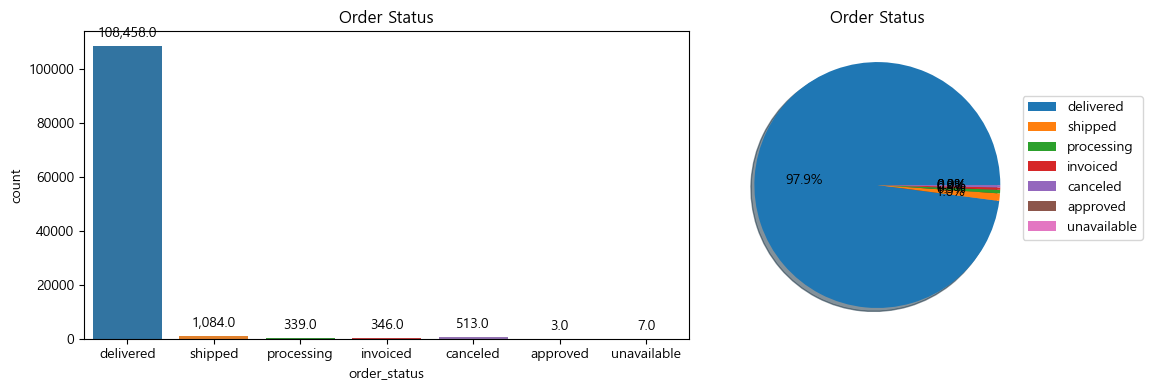

In [269]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
ax=sns.countplot(x=df_jw_1.order_status)
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.title('Order Status')


plt.subplot(1, 2, 2)

plt.pie(df_jw_1['order_status'].value_counts(), autopct='%.1f%%', shadow=True)
plt.title('Order Status')
plt.tight_layout()
plt.legend(labels=df_jw_1['order_status'].unique(), loc='lower left', bbox_to_anchor=(0.95, 0.3))


plt.tight_layout()
plt.show()

#### order_status

#### review_score별 order_status

In [52]:

query = """
describe order_reviews
"""
get_query(query)


,Field,Type,Null,Key,Default,Extra
0,review_id,b'text',YES,,None,
1,order_id,b'text',YES,,None,
2,review_score,b'bigint',YES,,None,
3,review_comment_title,b'text',YES,,None,
4,review_comment_message,b'text',YES,,None,
5,review_creation_date,b'text',YES,,None,
6,review_answer_timestamp,b'text',YES,,None,


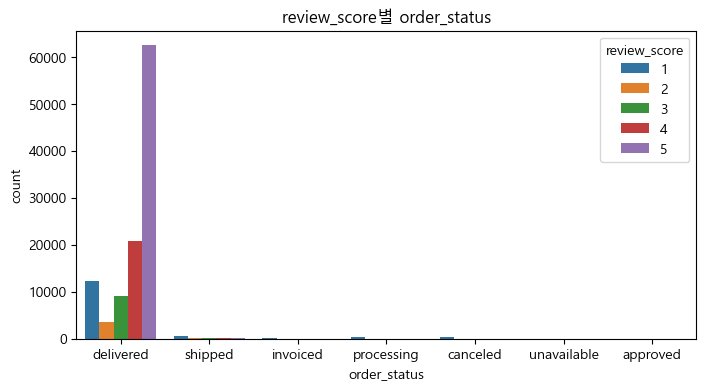

In [379]:
plt.figure(figsize=(8,4))
ax=sns.countplot(x='order_status', data=df_jw_1, hue='review_score')
plt.title('review_score별 order_status')
plt.show()

#### delivered 제외

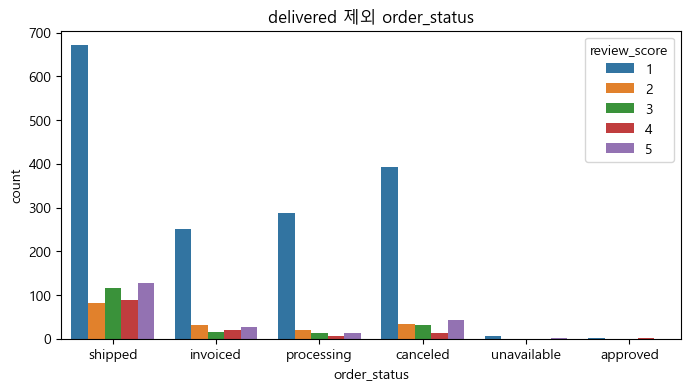

In [380]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x='order_status', data=df_jw_1[df_jw_1['order_status'] != 'delivered'], hue='review_score')

plt.title('delivered 제외 order_status')
plt.show()

#### 배송날짜

In [381]:
# pd.to_datetime

to_date=['order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date']

for i in to_date:
    df_jw_1[i]=pd.to_datetime(df_jw_1[i])


#### 배송 예측날짜 - 도착날짜 

In [382]:
df_jw_1['day_diff']=(df_jw_1['order_estimated_delivery_date']-df_jw_1['order_delivered_customer_date']).dt.days
df_jw_1.tail()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,day_diff
110745,8325d6e7af2f2bfb58cf040729b232dd,a1d53377ab83871b0ad483b03ac69d6c,3570,sao paulo,SP,b99217b1fcf2fdeace7b8d869b76cb91,delivered,2018-03-07 17:42:06,2018-03-07 17:55:36,2018-03-08 20:09:40,...,1.0,100.0,16.0,16.0,16.0,90010,porto alegre,RS,fashion_childrens_clothes,17.0
110746,f4b4417d306cbf8c55ea65c89d0261f7,27558f96bc671d0594c60be61566aeb4,46500,macaubas,BA,cab08f0417a702d0f4782ec02356a4ac,delivered,2017-09-30 18:54:53,2017-10-03 04:28:12,2017-10-03 18:54:12,...,3.0,300.0,30.0,20.0,20.0,3929,sao paulo,SP,fashion_childrens_clothes,1.0
110747,035c08a68b237ef4afc82109e61a7380,e4469e5047c00b0188885853d357d2ab,4116,sao paulo,SP,cb53f0b6e8f9082a9f5a113765dd1236,delivered,2018-06-03 22:34:58,2018-06-03 22:50:09,2018-06-04 15:15:00,...,3.0,300.0,30.0,20.0,20.0,3929,sao paulo,SP,fashion_childrens_clothes,22.0
110748,14acb30bbc064408dcb8cdd3c92b0c97,1b553902a5bbe6ee54a3aaa7cbfb6816,26255,nova iguacu,RJ,ee86b68eb9222b0cad7da50f4f758a35,delivered,2017-05-17 17:44:34,2017-05-17 17:55:12,2017-05-18 16:28:06,...,4.0,600.0,36.0,10.0,26.0,5685,sao paulo,SP,fashion_childrens_clothes,19.0
110749,2415312e36eac3ab3819f5b7f32522e5,1f83c87997168e248ea52ad3453b069f,4128,sao paulo,SP,3da4b0f0c89bb8fee8a810459e641414,delivered,2017-06-08 16:46:33,2017-06-08 18:20:19,2017-06-12 15:31:40,...,5.0,500.0,36.0,10.0,26.0,5685,sao paulo,SP,fashion_childrens_clothes,9.0


In [383]:
# 예상날짜와 실제 도착 날짜 평균 : 12일 차이
# 최소 : -189일
# 최대 : 146일 

df_jw_1.day_diff.describe()

count    108457.000000
mean         11.080271
std          10.086804
min        -189.000000
25%           6.000000
50%          12.000000
75%          16.000000
max         146.000000
Name: day_diff, dtype: float64

In [384]:
# 구매 날짜, 승인 날짜, 물류 파트너사 도착, 도착날짜, 예상날짜, 예상 - 도착
delivery_jw=df_jw_1[[ 'order_purchase_timestamp','order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date','order_estimated_delivery_date',  'day_diff', 'order_status']]
delivery_jw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110750 entries, 0 to 110749
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       110750 non-null  datetime64[ns]
 1   order_approved_at              110736 non-null  datetime64[ns]
 2   order_delivered_carrier_date   109605 non-null  datetime64[ns]
 3   order_delivered_customer_date  108457 non-null  datetime64[ns]
 4   order_estimated_delivery_date  110750 non-null  datetime64[ns]
 5   day_diff                       108457 non-null  float64       
 6   order_status                   110750 non-null  object        
dtypes: datetime64[ns](5), float64(1), object(1)
memory usage: 6.8+ MB


In [275]:
# 물류 파트너사에 도착했지만 못받은 물건이 1176건
delivery_jw.isnull().sum()

order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1145
order_delivered_customer_date    2293
order_estimated_delivery_date       0
day_diff                         2293
order_status                        0
dtype: int64

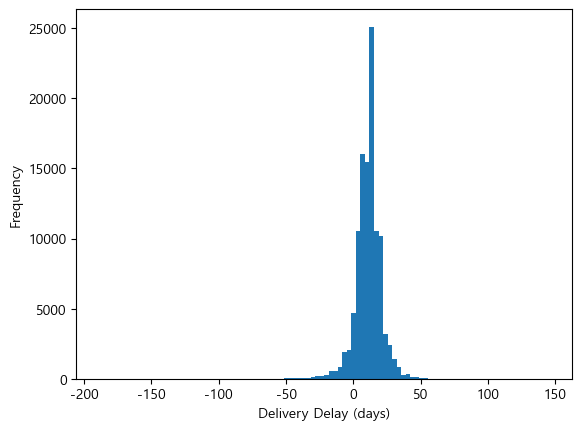

In [385]:
plt.rcParams['axes.unicode_minus'] = False


plt.hist(df_jw_1['day_diff'], bins=100)
plt.xlabel('Delivery Delay (days)')
plt.ylabel('Frequency')
plt.show()

#### 년도&월별 주문 수

In [386]:
# 2018년 55076건으로 가장 높음

orders_by_year_jw = olist_orders.groupby(df_jw_1['order_delivered_customer_date'].dt.year)['order_id'].count()
orders_by_year_jw

order_delivered_customer_date
2016.0      286
2017.0    42026
2018.0    55076
Name: order_id, dtype: int64

In [393]:
# 월별 배달 수
# 배달 6000건 넘는 월 : 2018-04, 2018-08, 2017-12, 2018-03, 2018-05, 2018-06, 2018-01
orders_by_month_jw = olist_orders.groupby(df_jw_1['order_delivered_customer_date'].dt.to_period('M'))['order_id'].count()

#### 년도별 주문 수 증가 시각화

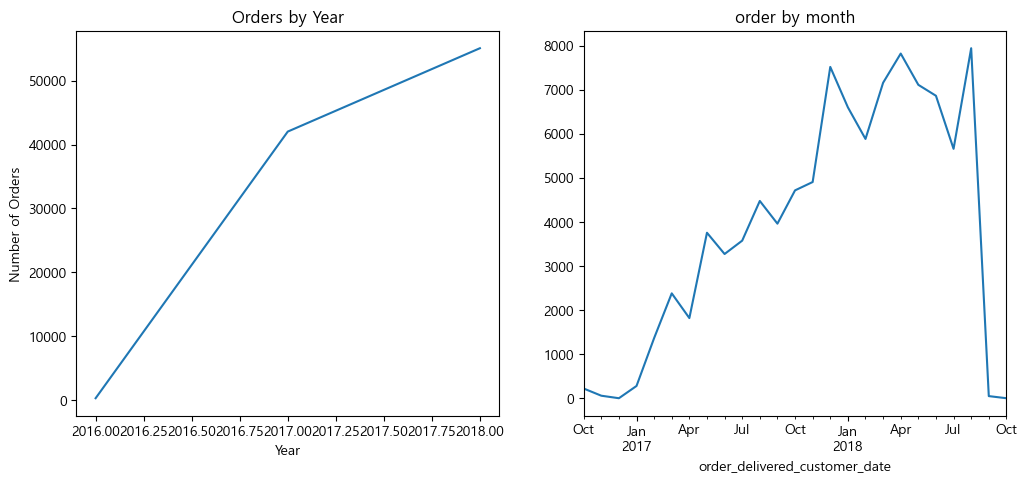

In [456]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
orders_by_year_jw.plot(kind='line')
plt.title('Orders by Year')
plt.xlabel('Year')
plt.ylabel('Number of Orders')


plt.subplot(1,2,2)
orders_by_month_jw.plot(kind='line')
plt.title('order by month')
plt.grid(False)

plt.show()

#### 배달 완료 가장 많은 달

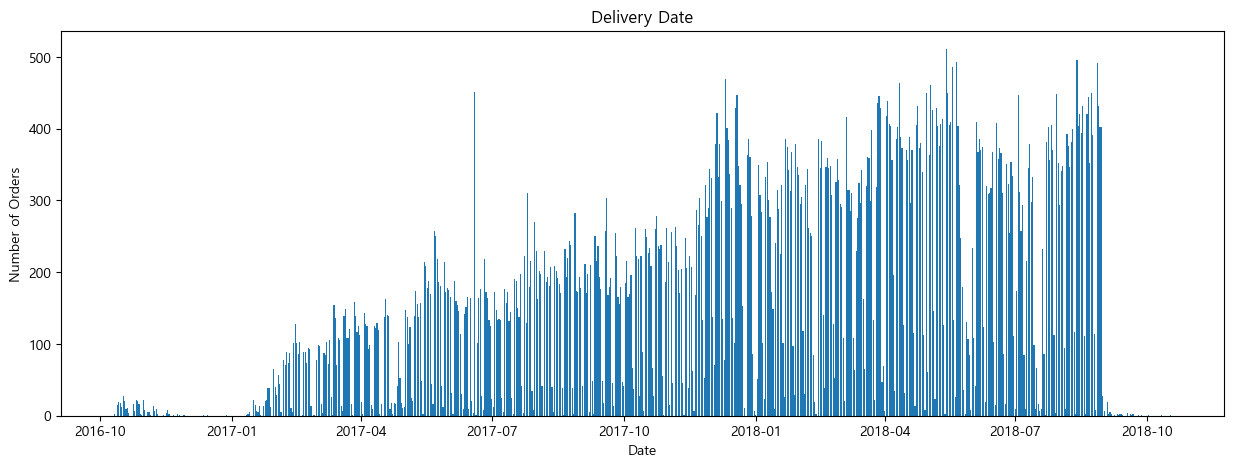

In [465]:
daily_orders_jw = df_jw_1['order_delivered_customer_date'].dt.date.value_counts().sort_index()

plt.figure(figsize=(15,5))
plt.bar(daily_orders_jw.index, daily_orders_jw.values)
plt.title('Delivery Date')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

#### 배송 취소한 구매날짜

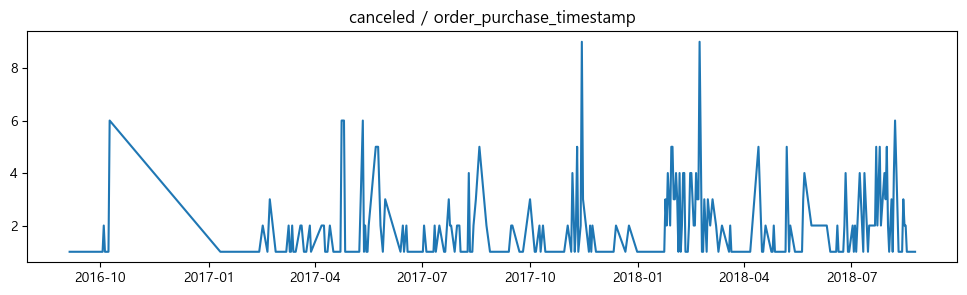

In [396]:
df_jw_1.loc[df_jw_1['order_status'] == 'canceled', 'order_purchase_timestamp'].dt.date.value_counts().plot(figsize=(12,3))
plt.title('canceled / order_purchase_timestamp')
plt.grid(False)

#### 배송 많은 top10 지역

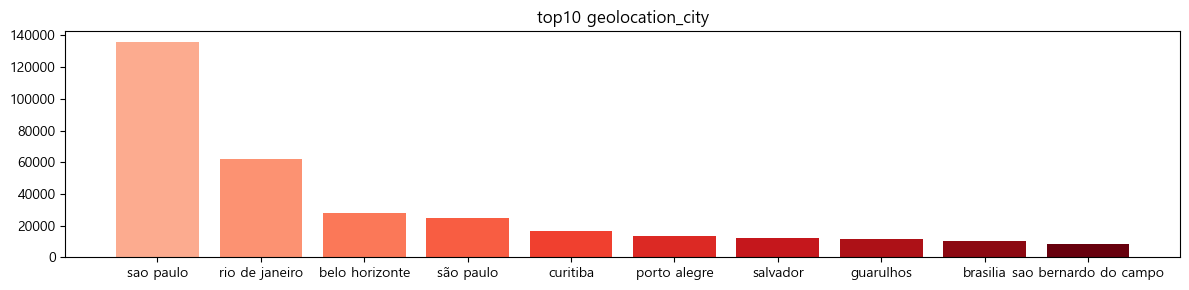

In [180]:
olist_geolocation.geolocation_city.value_counts()[:10]

values_jw = olist_geolocation.geolocation_city.value_counts()[:10]
colors_jw = np.linspace(0.3, 1, len(values_jw))

plt.figure(figsize=(12, 3))
plt.bar(values_jw.index, values_jw, color=plt.cm.Reds(colors_jw))
plt.title('top10 geolocation_city')
plt.tight_layout()
plt.grid(False)
plt.show()

In [277]:
conn.close()

---